In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from tensorflow import keras
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score

In [2]:
df = pd.read_csv('/content/sample_data/bank-additional-full.csv', delimiter=';', na_values='?')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
print(df.shape)
print(df.isnull().sum())

(41188, 21)
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [5]:
df = df.rename(columns={'default': 'creditDefault', 'housing': 'houseLoan', 'loan':'personalLoan', 'contact': 'contactType',
                       'month': 'contactMonth', 'day': 'contactDay', 'duraction':'contactDuration', 'emp.var.rate':'emp_var_rate',
                        'cons.conf.idx':'con_confi_idx','cons.price.idx':'cons_price_idx','nr.employed':'noOfEmployee'})

Categorical Features

In [6]:
object_columns = df.select_dtypes(include='object').columns

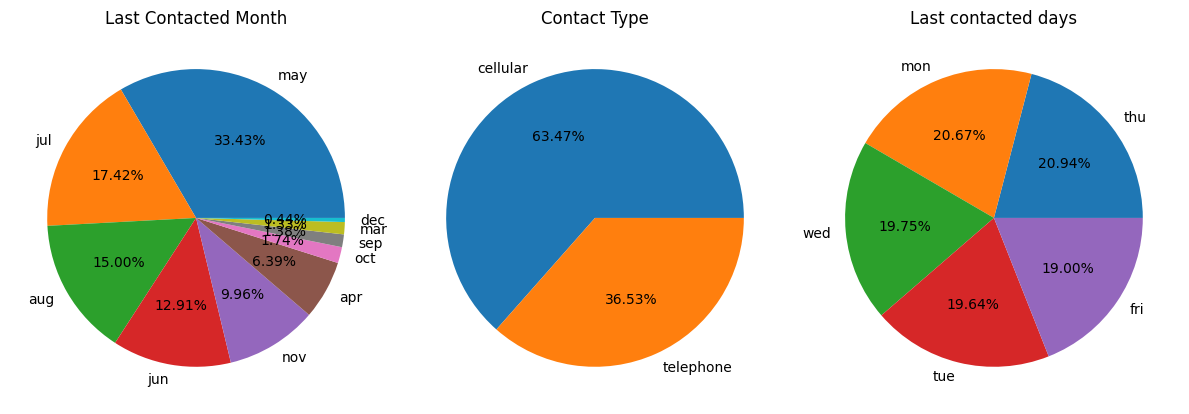

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
day_counts = df['day_of_week'].value_counts()
type_counts = df['contactType'].value_counts()
mon_counts = df['contactMonth'].value_counts()
axes[0].pie(mon_counts, labels=mon_counts.index, autopct='%1.2f%%')
axes[0].set_title('Last Contacted Month')
axes[1].pie(type_counts, labels=type_counts.index, autopct='%1.2f%%')
axes[1].set_title('Contact Type')
axes[2].pie(day_counts, labels=day_counts.index, autopct='%1.2f%%')
axes[2].set_title('Last contacted days')
plt.tight_layout()
plt.show()

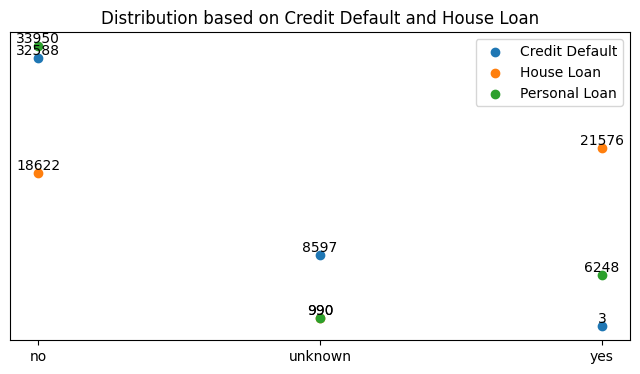

In [8]:
cre_counts = df['creditDefault'].value_counts()
loan_counts = df['houseLoan'].value_counts()
per_counts = df['personalLoan'].value_counts()
plt.figure(figsize=(8, 4))
plt.scatter(cre_counts.index, cre_counts.values, label='Credit Default')
for x, y in zip(cre_counts.index, cre_counts.values):
    plt.annotate(str(y), xy=(x, y), ha='center', va='bottom')
plt.scatter(loan_counts.index, loan_counts.values, label='House Loan')
for x, y in zip(loan_counts.index, loan_counts.values):
    plt.annotate(str(y), xy=(x, y), ha='center', va='bottom')
plt.scatter(per_counts.index, per_counts.values, label='Personal Loan')
for x, y in zip(per_counts.index, per_counts.values):
    plt.annotate(str(y), xy=(x, y), ha='center', va='bottom')
plt.yticks([])
plt.title('Distribution based on Credit Default and House Loan')
plt.legend()
plt.show()

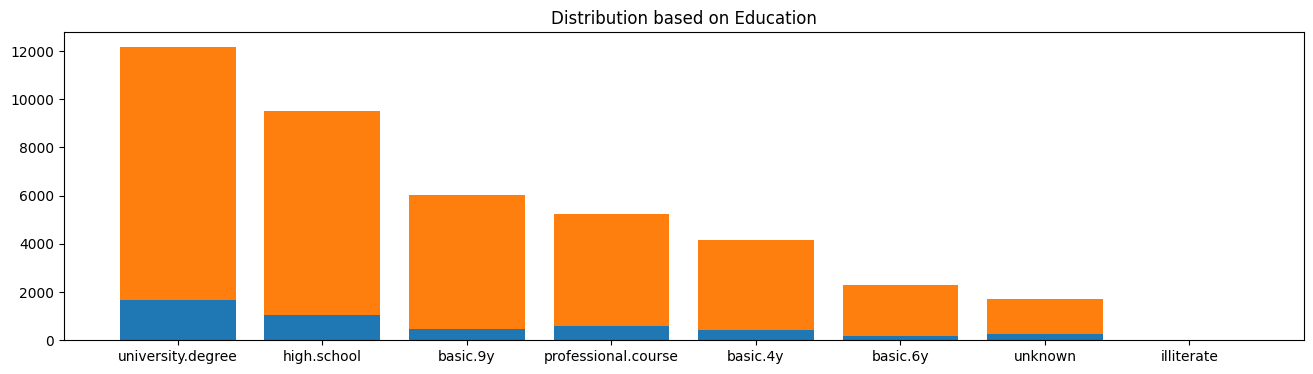

In [9]:
edu_counts = df['education'].value_counts()
categories = edu_counts.index.tolist()
plt.figure(figsize=(16, 4))
positive_counts = df.loc[df['y'] == 'yes', 'education'].value_counts()
positive_values = [positive_counts.get(category, 0) for category in categories]
negative_counts = df.loc[df['y'] == 'no', 'education'].value_counts()
negative_values = [negative_counts.get(category, 0) for category in categories]
plt.bar(categories, positive_values, label='Yes')
plt.bar(categories, negative_values, bottom=positive_values, label='No')
plt.title('Distribution based on Education')
plt.show()

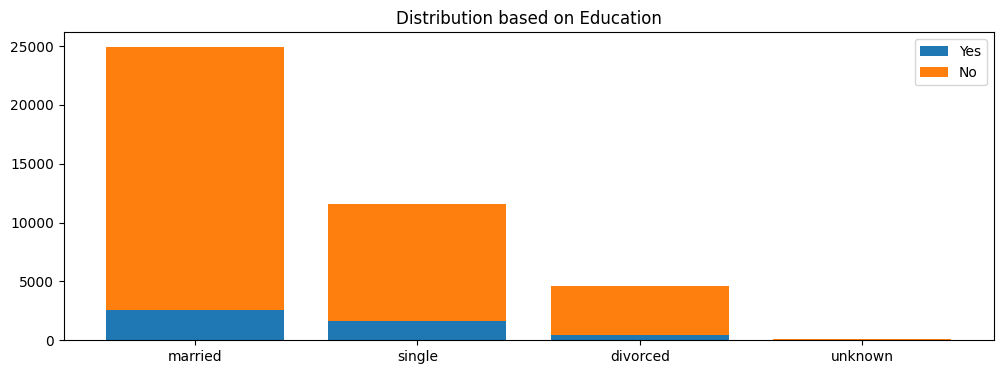

In [10]:
marital_counts = df['marital'].value_counts()
categories = marital_counts.index.tolist()
plt.figure(figsize=(12, 4))
positive_counts = df.loc[df['y'] == 'yes', 'marital'].value_counts()
positive_values = [positive_counts.get(category, 0) for category in categories]
negative_counts = df.loc[df['y'] == 'no', 'marital'].value_counts()
negative_values = [negative_counts.get(category, 0) for category in categories]
plt.bar(categories, positive_values, label='Yes')
plt.bar(categories, negative_values, bottom=positive_values, label='No')
plt.title('Distribution based on Education')
plt.legend()
plt.show()

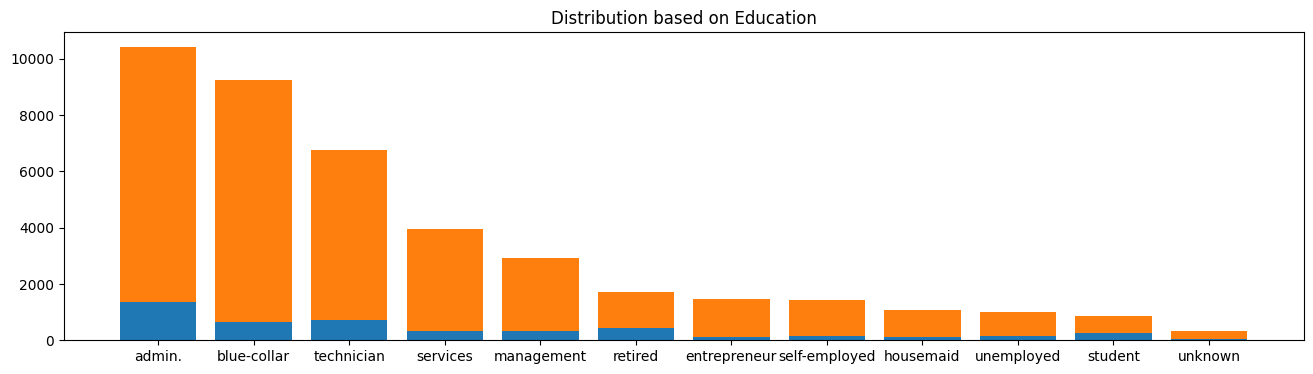

In [11]:
job_counts = df['job'].value_counts()
categories = job_counts.index.tolist()
plt.figure(figsize=(16, 4))
positive_counts = df.loc[df['y'] == 'yes', 'job'].value_counts()
positive_values = [positive_counts.get(category, 0) for category in categories]
negative_counts = df.loc[df['y'] == 'no', 'job'].value_counts()
negative_values = [negative_counts.get(category, 0) for category in categories]
plt.bar(categories, positive_values, label='Yes')
plt.bar(categories, negative_values, bottom=positive_values, label='No')
plt.title('Distribution based on Education')
plt.show()

In [12]:
unknown_data = df[df['creditDefault'].eq('unknown') & df['houseLoan'].eq('unknown') & df['personalLoan'].eq('unknown') &
                  df['job'].eq('unknown') & df['education'].eq('unknown') & df['poutcome'].eq('nonexistent')]
grouped_data = unknown_data.groupby(['job','education','creditDefault', 'houseLoan', 'personalLoan','poutcome']).size().reset_index(name='count')
print(grouped_data)

       job education creditDefault houseLoan personalLoan     poutcome  count
0  unknown   unknown       unknown   unknown      unknown  nonexistent      2


### Numerical Features

In [13]:
df.shape

(41188, 21)

In [14]:
def categorize_age(age_column):
    categories = []
    for age in age_column:
        if age >= 65:   #oldAge
            categories.append(1)
        elif age < 65: #adult
            categories.append(2)
    return categories

age = categorize_age(df['age'])
df['ageCategory'] = age

def seconds_to_days(seconds):
    days = seconds / 60
    return days
minutes = seconds_to_days(df['duration'])
df['minutes'] = minutes

def categorize_pervious(col):
    categories = []
    for c in col:
        if c != 999:   #oldAge
            categories.append(1)
        elif c == 999: #adult
            categories.append(0)
    return categories

pdays = categorize_pervious(df['pdays'])
df = df.drop(['duration', 'age', 'pdays'], axis=1)
df['pdays'] = pdays

In [15]:
non_object = df.select_dtypes(include=['int64']).columns
print(non_object)

Index(['campaign', 'previous', 'ageCategory', 'pdays'], dtype='object')


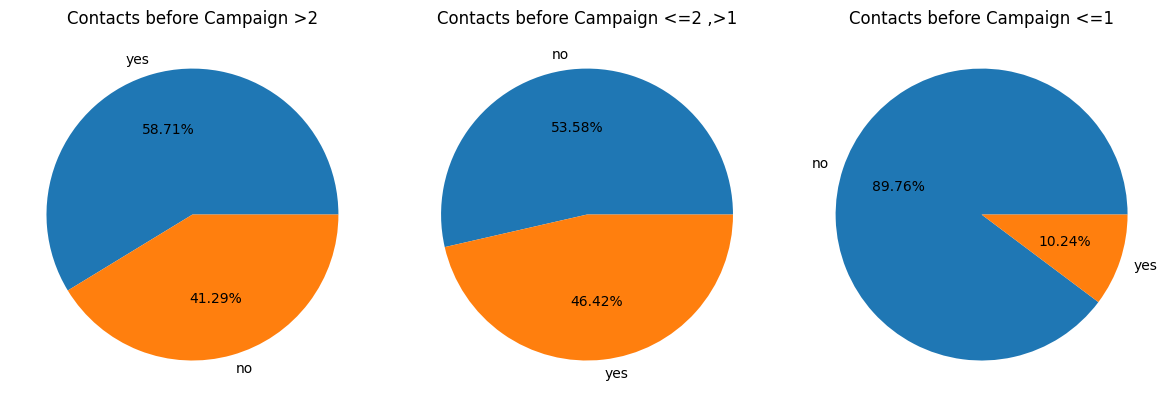

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
c1 = df.loc[(df['previous'] > 2), 'y'].value_counts()
c2 = df.loc[(df['previous'] <= 2) & (df['previous'] > 1), 'y'].value_counts()
c3 = df.loc[(df['previous'] <= 1) & (df['previous'] >= 0), 'y'].value_counts()
axes[0].pie(c1, labels=c1.index, autopct='%1.2f%%')
axes[0].set_title('Contacts before Campaign >2')
axes[1].pie(c2, labels=c2.index, autopct='%1.2f%%')
axes[1].set_title('Contacts before Campaign <=2 ,>1')
axes[2].pie(c3, labels=c3.index, autopct='%1.2f%%')
axes[2].set_title('Contacts before Campaign <=1')
plt.tight_layout()
plt.show()

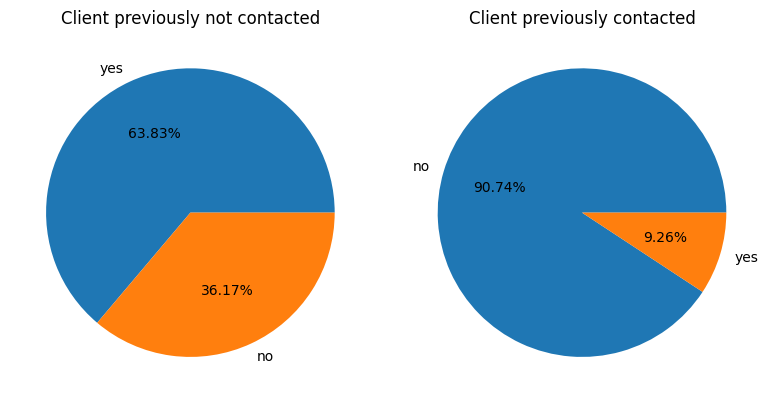

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
d1 = df.loc[(df['pdays'] == 1) , 'y'].value_counts()
d2 = df.loc[(df['pdays'] != 1) , 'y'].value_counts()
axes[0].pie(d1, labels=d1.index, autopct='%1.2f%%')
axes[0].set_title('Client previously not contacted')
axes[1].pie(d2, labels=d2.index, autopct='%1.2f%%')
axes[1].set_title('Client previously contacted')
plt.tight_layout()
plt.show()

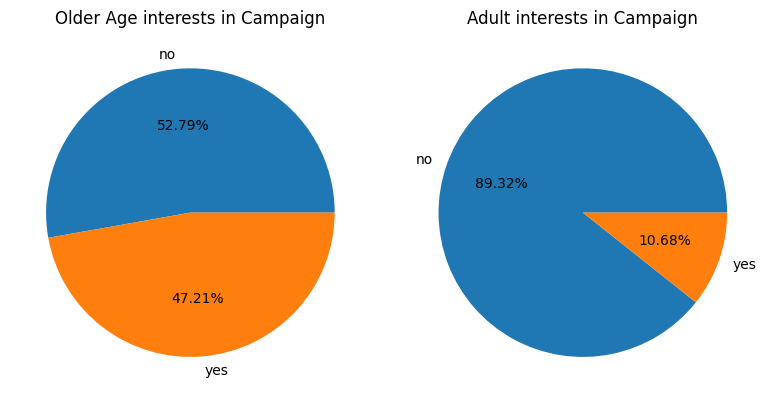

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
category1 = df.loc[(df['ageCategory'] == 1), 'y'].value_counts()
category2 = df.loc[(df['ageCategory'] == 2), 'y'].value_counts()
axes[0].pie(category1, labels=category1.index, autopct='%1.2f%%')
axes[0].set_title('Older Age interests in Campaign')
axes[1].pie(category2, labels=category2.index, autopct='%1.2f%%')
axes[1].set_title('Adult interests in Campaign')
plt.tight_layout()
plt.show()

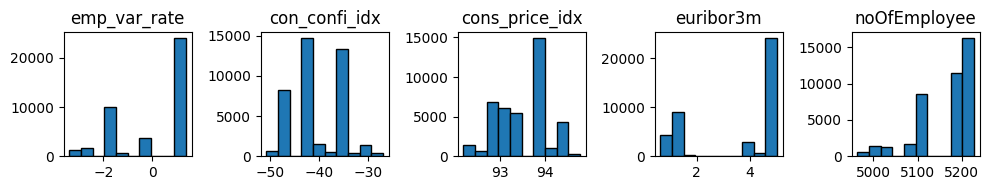

In [19]:
non_object_1 = df.select_dtypes(include=['float64']).columns
columns = ['emp_var_rate', 'con_confi_idx', 'cons_price_idx', 'euribor3m', 'noOfEmployee']
fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(10, 2))
for i, col in enumerate(columns):
    axes[i].hist(df[col], bins=10, edgecolor='black')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

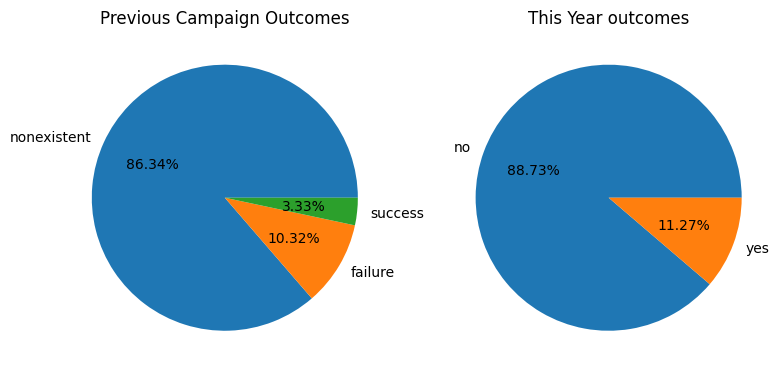

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
label_counts = df['y'].value_counts()
out_counts = df['poutcome'].value_counts()
axes[0].pie(out_counts, labels=out_counts.index, autopct='%1.2f%%')
axes[0].set_title('Previous Campaign Outcomes')
axes[1].pie(label_counts, labels=label_counts.index, autopct='%1.2f%%')
axes[1].set_title('This Year outcomes')
plt.tight_layout()
plt.show()

In [21]:
# df = df.drop(columns=['emp_var_rate', 'con_confi_idx', 'cons_price_idx', 'euribor3m', 'noOfEmployee'])
df = df.drop(columns=['euribor3m', 'noOfEmployee', 'cons_price_idx'])

In [22]:
df.head(10)

,job,marital,education,creditDefault,houseLoan,personalLoan,contactType,contactMonth,day_of_week,campaign,previous,poutcome,emp_var_rate,con_confi_idx,y,ageCategory,minutes,pdays
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,-36.4,no,2,4.350000,0
1,services,married,high.school,unknown,no,no,telephone,may,mon,1,0,nonexistent,1.1,-36.4,no,2,2.483333,0
2,services,married,high.school,no,yes,no,telephone,may,mon,1,0,nonexistent,1.1,-36.4,no,2,3.766667,0
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,-36.4,no,2,2.516667,0
4,services,married,high.school,no,no,yes,telephone,may,mon,1,0,nonexistent,1.1,-36.4,no,2,5.116667,0
5,services,married,basic.9y,unknown,no,no,telephone,may,mon,1,0,nonexistent,1.1,-36.4,no,2,3.300000,0
6,admin.,married,professional.course,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,-36.4,no,2,2.316667,0
7,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,1,0,nonexistent,1.1,-36.4,no,2,3.616667,0
8,technician,single,professional.course,no,yes,no,telephone,may,mon,1,0,nonexistent,1.1,-36.4,no,2,6.333333,0
9,services,single,high.school,no,yes,no,telephone,may,mon,1,0,nonexistent,1.1,-36.4,no,2,0.833333,0


In [23]:
columns_to_encode = ['marital', 'creditDefault','houseLoan','job','personalLoan','contactType',
                     'contactMonth','day_of_week','poutcome']
df = pd.get_dummies(df, columns=columns_to_encode)
print(df.shape)

(41188, 54)


In [24]:
def labels_prediction(label):
    category = []
    for c in label:
        if c == 'yes':
            category.append(1)
        elif c == 'no':
            category.append(0)
    return category
labels = pd.DataFrame(labels_prediction(df['y']))

In [25]:
labels = np.ravel(labels)
features = df.drop(columns=['y','education'])
print(features.shape)

(41188, 52)


In [26]:
X_train,X_test,y_train,y_test = train_test_split(features,labels, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(32950, 52) (8238, 52) (32950,) (8238,)


In [27]:
lgb = LGBMClassifier()
model = lgb.fit(X_train,y_train)
lgb_pred = lgb.predict(X_test)
print('Accuracy Score is: ',accuracy_score(y_test, lgb_pred))
print('Recall Score is',recall_score(y_test,lgb_pred),'\n\n')

Accuracy Score is:  0.9161204175770818
Recall Score is 0.5336898395721925 




In [28]:
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

In [29]:
# from sklearn.ensemble import GradientBoostingClassifier
# ensemble_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model1 = LGBMClassifier()
undersampling_ratio = 0.3
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores = []
recalls = []
precisions = []
for train_index, test_index in kf.split(features, labels):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    undersampler = RandomUnderSampler(sampling_strategy=undersampling_ratio, random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(features, labels)
    model1.fit(X_resampled, y_resampled)
    y_pred = model1.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recalle = recall_score(y_test,y_pred)
    precisione = precision_score(y_test, y_pred)
    scores.append(accuracy)
    recalls.append(recalle)
    precisions.append(precisione)
mean_accuracy = np.mean(scores)
print("Mean Accuracy:", mean_accuracy)
recall_score = np.mean(recalls)
print("Mean recall score:", recall_score)
precision_score = np.mean(precisions)
print("Mean precision score:", precision_score)

Mean Accuracy: 0.9133001827417738
Mean recall score: 0.8336206896551724
Mean precision score: 0.5803742323865737
